# The social network of Caesar's *Bellum Gallicum*

## Data Flow

The data will be collected from a reduced version (extracts) of the *Bellum Gallicum*, which has been manually annotated for morphology and syntax according to the Universal Dependency model, in the CoNLL-U format.

See the [GitHub repository](https://github.com/proiel/proiel-treebank/blob/master/caes-gal.conll).

### The components of the CoNLL-U annotation schema

CoNLL-U annotations are distributed as plain text files.

The annotation files contain three types of lines: **comment lines**, **word lines** and **blank lines**.

**Comment lines** precede word lines and start with a hash character (#). These lines can be used to provide metadata about the word lines that follow.

Each **word line** contains annotations for a single word or token. Larger linguistic units are represented by subsequent word lines.

The annotations for a word line are provided using the following fields, each separated by a tabulator character:

```console
ID	FORM	LEMMA	UPOS	XPOS	FEATS	HEAD	DEPREL	DEPS	MISC
```

 1. `ID`: Index of the word in sequence
 2. `FORM`: The form of a word or punctuation symbol
 3. `LEMMA`: Lemma or the base form of a word
 4. `UPOS`: [Universal part-of-speech tag](https://universaldependencies.org/u/pos/)
 5. `XPOS`: Language-specific part-of-speech tag
 6. `FEATS`: [Morphological features](https://universaldependencies.org/u/feat/index.html)
 7. `HEAD`: Syntactic head of the current word
 8. `DEPREL`: Universal dependency relation to the `HEAD`
 9. `DEPS`: [Enhanced dependency relations](https://universaldependencies.org/u/overview/enhanced-syntax.html)
 10. `MISC`: Any additional annotations

Finally, a **blank line** after word lines is used to separate sentences.

For reading and managing the CoNNL-U formatted file, we will use Python [conllu](https://pypi.org/project/conllu/) library.

In [1]:
# Import the conllu library
import conllu

In [2]:
# Open the plain text file for reading; assign under 'data'
with open('caes_gal.conllu', mode="r", encoding="utf-8") as data:

    # Read the file contents and assign under 'annotations'
    annotations = data.read()
# Use the parse() function to parse the annotations; store under 'sentences'
sentences = conllu.parse(annotations)

The parse() function returns a Python list populated by TokenList objects, native to pyconll library.

In [3]:
# print the first token (TokenList object) of the first sentence (list).
# sentences[0][0]

### Data processing

First of all, we want to extract the NE from the annotations. Although proper nouns are already marked as such in `annotations`, we don't need to perform an actual NE recognition. Nevertheless, since sentences are annotated token-by-token, in case of multi-token names we need to group the tokens that are associated with the same entity, i.e. are part of the full name of a character. To do so, we can rely on the consistency of the annotation procedure, for which the "second names" are marked as direct dependants of the "first name" token by a 'flat:name' relation.
Once done so, we build a relation between two entities in the same sentence and assign to the relation a value, based on how close the entities are in the syntactic tree of the sentence:
- if ent1 and ent2 share the same head -> value = 3
- if ent1 is head of ent2 or vice versa -> value = 2
- if ent1's head is the head of the head of ent2, or vice versa -> value = 1
- if ent1's head shares head of ent2's head (common grandparent) -> value = 0.5

Finally, we merge eventual multiple instances of the same relation (summing the value of each instance) and remove form the list of relations those involving places instead of person (using an external list).

In [4]:
from data_processing import clean_relations_instances, get_dependency_relations

relations = clean_relations_instances(get_dependency_relations(sentences))
characters = list({i for i in relations if type(i) == str})

# Let's build the graph!

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint

edges = relations
#nodes = characters

G = nx.Graph()

# for n in nodes:
#     G.add_node(n)

for item in edges:
    G.add_edge(item[0], item[1], weight=item[2])

In [6]:
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())
print('Graph connectedness:' , nx.is_connected(G)) # Graph is not connected! --> implications on betweenness_centrality

Number of nodes:  62
Number of edges:  65
Graph connectedness: False


In [7]:
# print(G.edges().data())

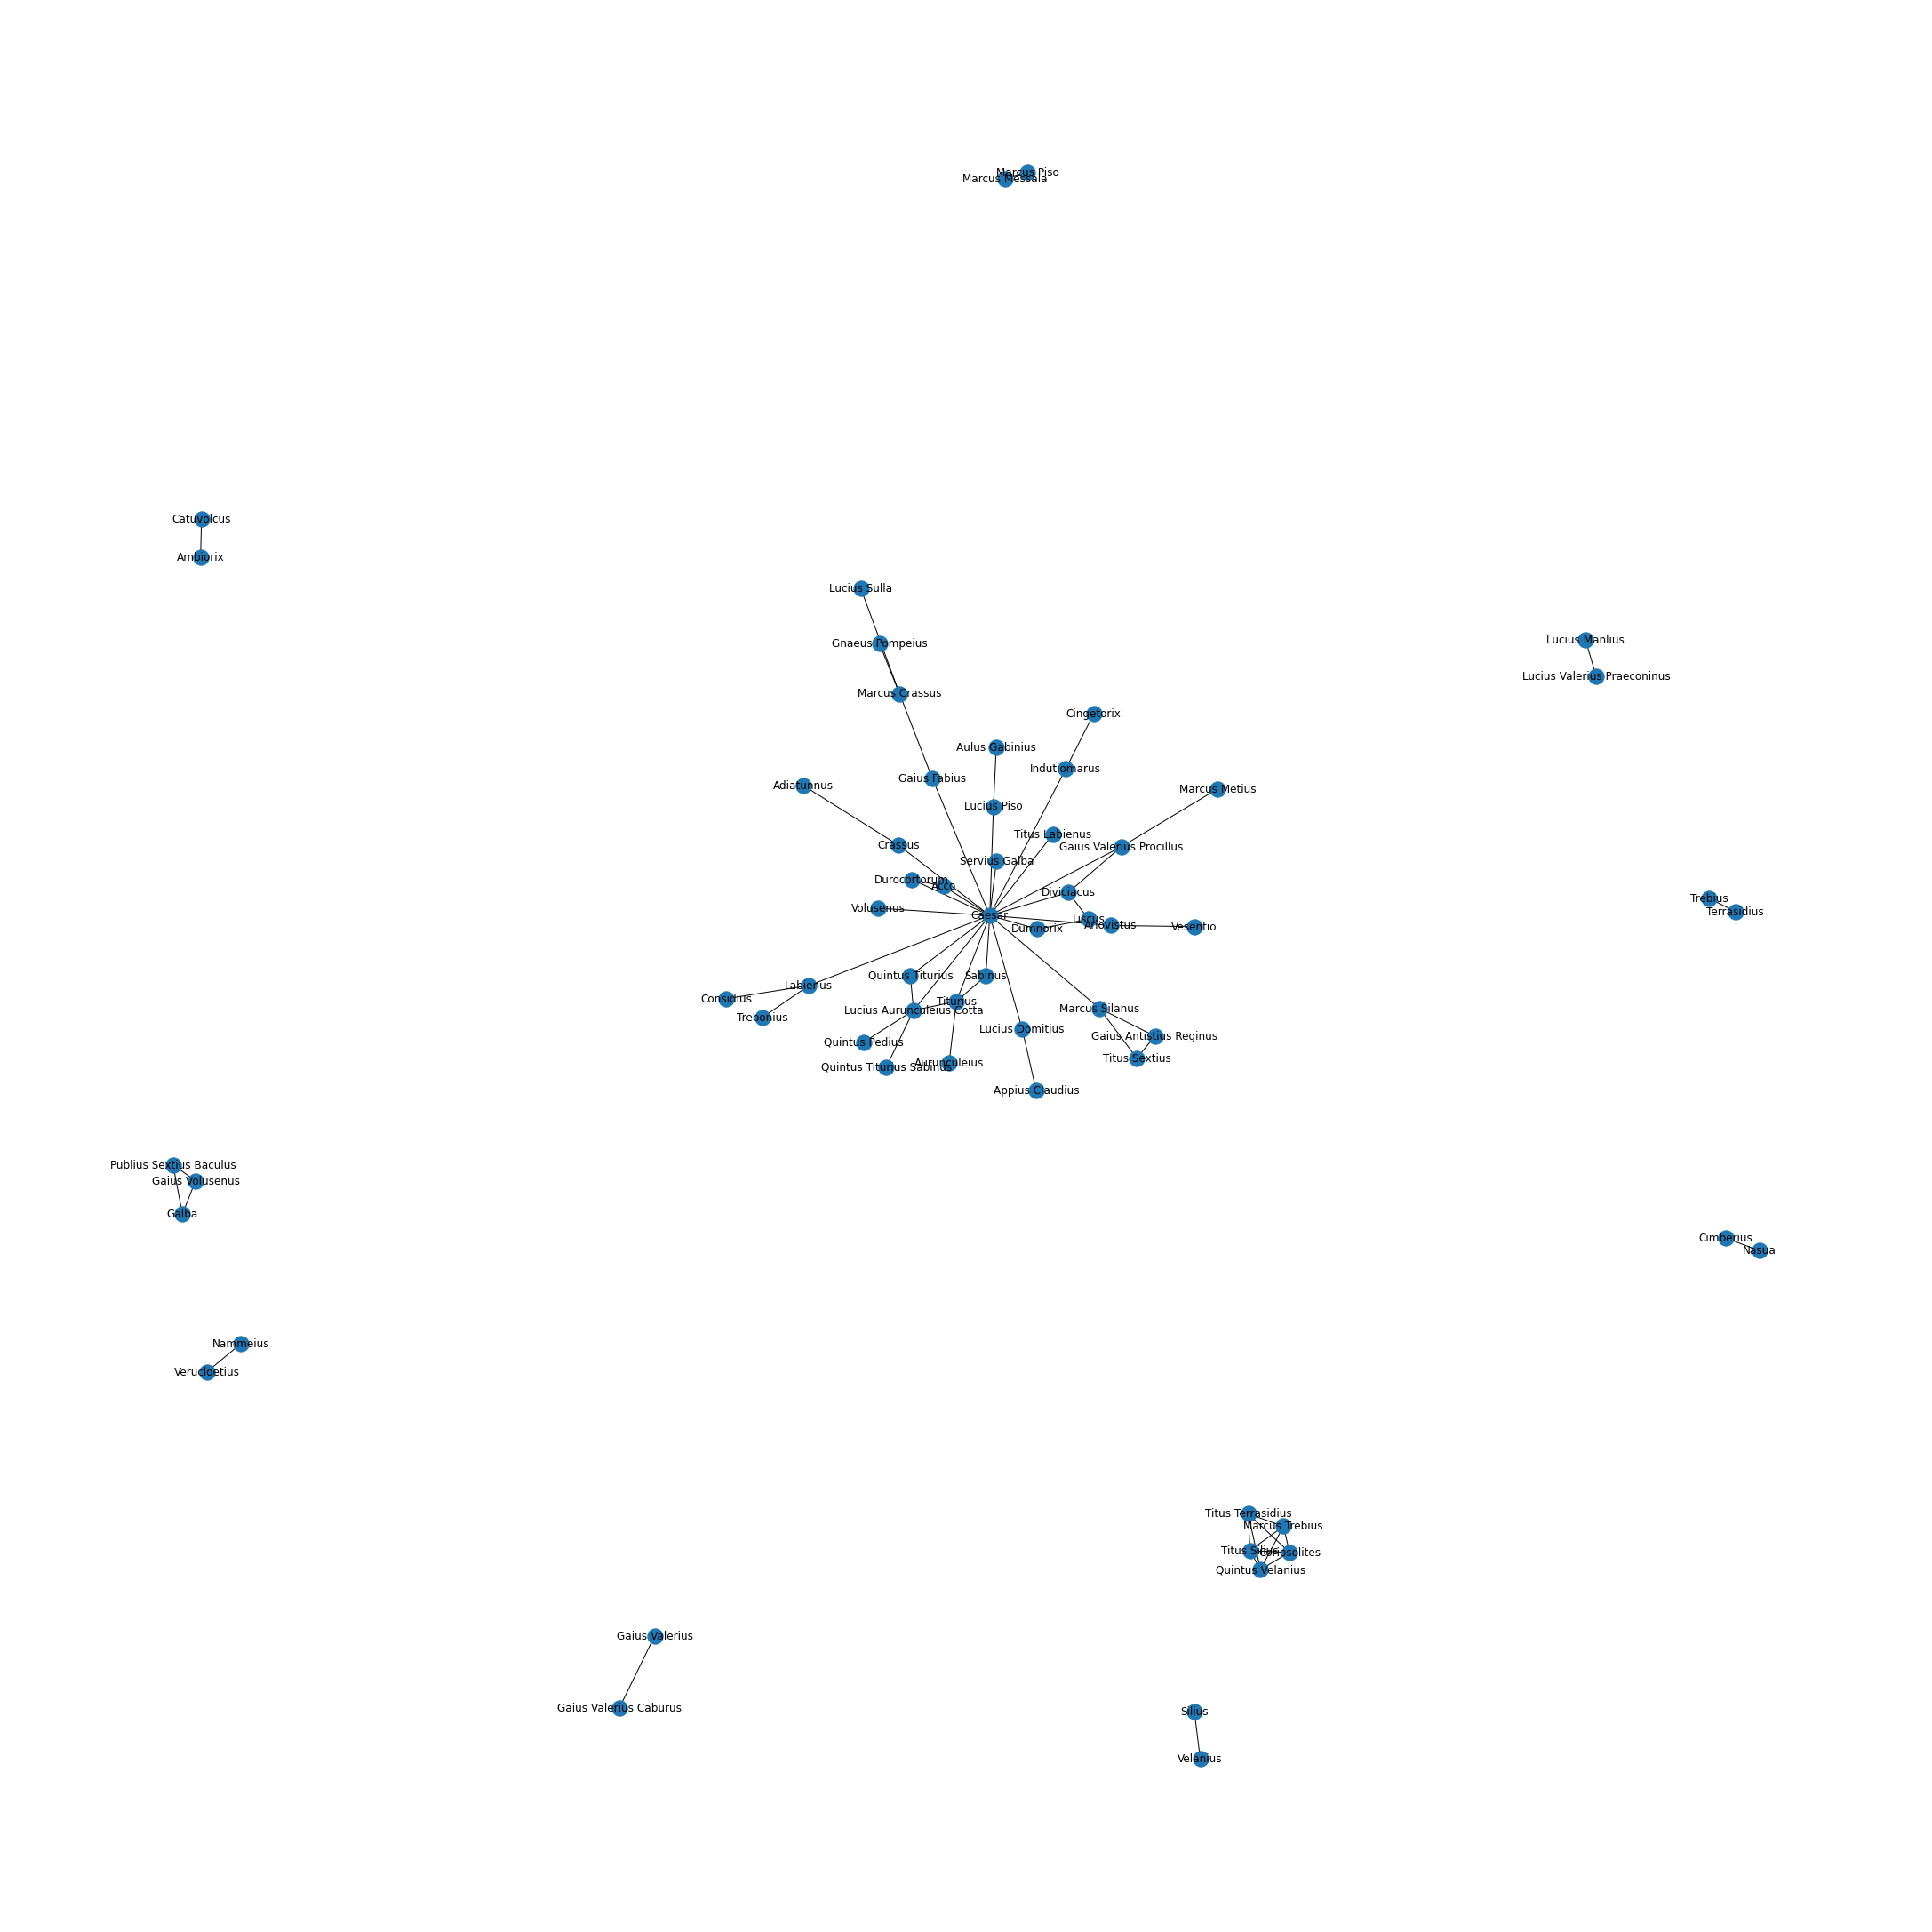

In [8]:
# VISUALIZATION
plt.figure(figsize=(30,30))
nx.draw(G, with_labels=True) # with_labels=True for showing node's label
plt.savefig("graph.png")
# plt.show()

In [9]:
## INTERACTIVE WEB VISUALIZATION

from pyvis.network import Network

net = Network(notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color='white')

net.from_nx(G)
net.show("caes_net.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [10]:
nx.write_gexf(G, "out/gephi_net.gexf") # save to .gefx format for opening in gephi

### Measures

In [11]:
degrees = dict(nx.degree(G)) # high number of interactions for important nodes
degree_centrality = nx.degree_centrality(G) # more interactions for important nodes
betweenness_centrality = nx.betweenness_centrality(G) # more power in passing information (computed only for the big component when graph is not connected)
closeness_centrality = nx.closeness_centrality(G) # easy communication of important nodes (not suitable for disconnected graphs)
harmonic_centrality = nx.harmonic_centrality(G) # alternative to closeness centrality for disconnected graphs
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')
density = nx.density(G)
# diameter = nx.diameter() # not possible, since the graph is disconnected https://stackoverflow.com/a/69636529/20184608
clustering_coefficient = nx.clustering(G, weight='weight') # not used

('Crassus', 2)


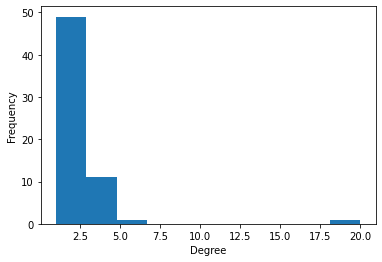

In [12]:
print(sorted(degrees.items(), key=lambda x:x[1], reverse=True)[20]) # print top 20 nodes with highest value

plt.hist(list(degrees.values()))
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig("out/degrees.png")
plt.savefig("out/degrees.svg")
plt.show()

('Crassus', 0.03278688524590164)


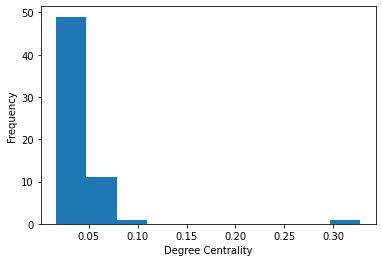

In [13]:
print(sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)[20]) # print top 20 nodes with highest value

plt.hist(list(degree_centrality.values()))
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.savefig("out/degree_centrality.png")
plt.savefig("out/degree_centrality.svg")
plt.show()

##### Betweenness centrality and centralization
We compute betweennes centrality and see if a small number of nodes have much higher degree centrality values than the others. The betweenness centrality computation is weighted and performed considering only on the biggest component (since the graph is not connected).

('Verucloetius', 0.0)


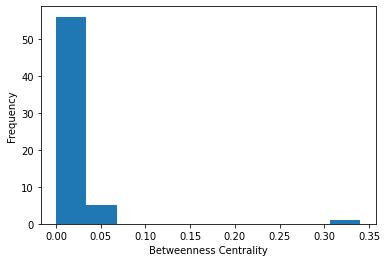

In [14]:
print(sorted(betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[20]) # print top 20 nodes with highest value

plt.hist(list(betweenness_centrality.values()))
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.savefig("out/betweenness_centrality.png")
plt.savefig("out/betwenness_centrality.svg")
plt.show()

('Titus Labienus', 0.24394155381325733)


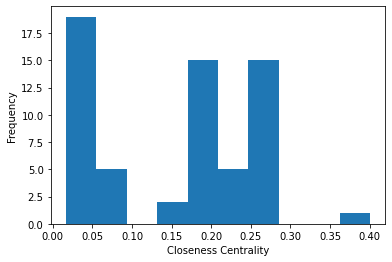

In [15]:
print(sorted(closeness_centrality.items(), key=lambda x:x[1], reverse=True)[20]) # print top 20 nodes with highest value

plt.hist(list(closeness_centrality.values()))
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.savefig("out/closeness_centrality.png")
plt.savefig("out/closeness_centrality.svg")
plt.show()

('Servius Galba', 16.000000000000004)


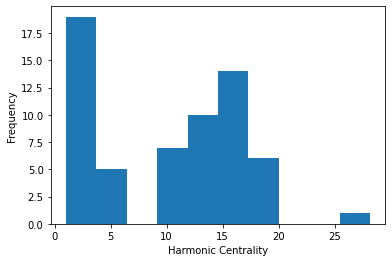

In [16]:
print(sorted(harmonic_centrality.items(), key=lambda x:x[1], reverse=True)[20]) # print top 20 nodes with highest value

plt.hist(list(harmonic_centrality.values()))
plt.xlabel('Harmonic Centrality')
plt.ylabel('Frequency')
plt.savefig("out/harmonic_centrality.png")
plt.savefig("out/harmonic_centrality.svg")
plt.show()

##### Eigenvector centrality
The value of the Eigenvector centrality (centrality of a node based on the centrality of its neighbors) of each node can be interpreted as a measure of how “important” is each individual, since we would expect that “important” individuals (such as Caesar and other Roman generals) interact more frequently with other important individuals than they do with “minor” actors.

('Titus Labienus', 0.13478891830250225)


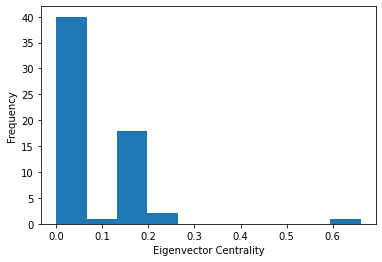

In [17]:
print(sorted(eigenvector_centrality.items(), key=lambda x:x[1], reverse=True)[20]) # print top 20 nodes with highest value

plt.hist(list(eigenvector_centrality.values()))
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.savefig("out/eigenvector_centrality.png")
plt.savefig("out/eigenvector_centrality.svg")
plt.show()

#### Adjacency matrix

In [18]:
import pandas as pd

adj_matrix = nx.adjacency_matrix(G)
adj_matrix_df = pd.DataFrame.sparse.from_spmatrix(adj_matrix)

C:\Users\media\AppData\Local\Temp/ipykernel_4036/2379880176.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


#### Caesar's ego network

21


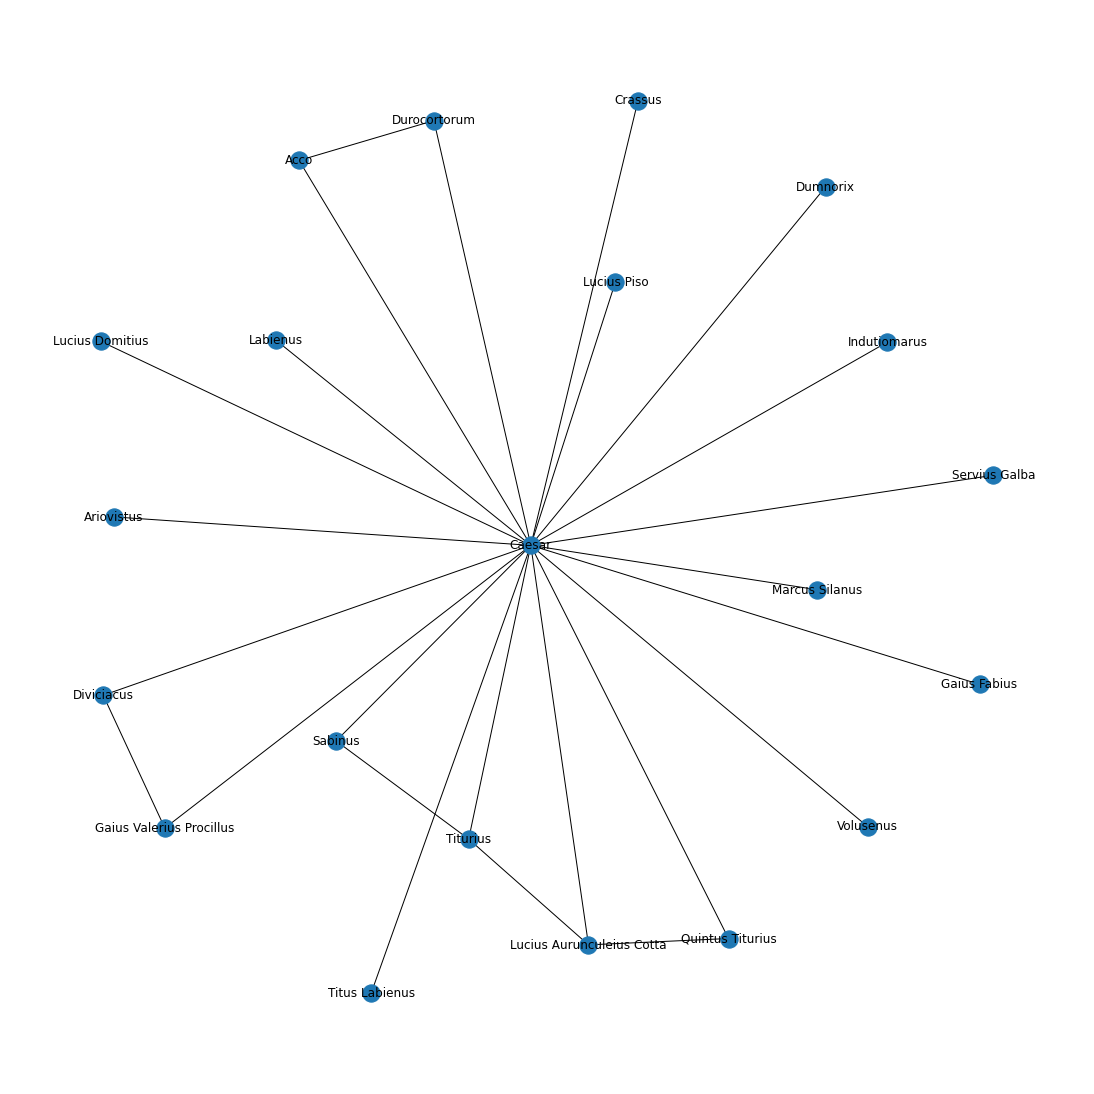

In [19]:
Caesar = nx.ego_graph(G, 'Caesar')
# VISUALIZATION
plt.figure(figsize=(15,15))
nx.draw(Caesar, with_labels=True) # with_labels=True for showing node's label
plt.savefig("out/caesar_ego_graph.png")
plt.savefig("out/caesar_ego_graph.svg")
print(nx.number_of_nodes(Caesar))
plt.show()

#### K-cores

In order to indentify relevant set of nodes, k_cores are looked for in the graph. From computing `nx.core_number(G)`, we see that the great majority of nodes have core number 1 (the core number of a node is the largest value k of a k-core containing that node), therefore we expect the subgraph for k=2 to be substantially different from the original one.

For k=2, the Caesar's node is still in the (sub)graph, while for k>=3, only one core remains. This decomposition of the graph in cores could be used to identiy the core-periphery structure of the network, where the nodes "remaining" in the graph at the highest value of k would be the central "core" of the network, and the ones removed the periphery. The disconnectedness of graph, though, makes this interpretation deceiving: the remaining core is definitely less relevant for the whole network than the bigger cores we find at k=2.

In [20]:
core_k_by_node = nx.core_number(G)
core_k_by_node # max number of k for each node, ie the number of nodes each node can be connected to so that all the nodes in that core are connected

{'Marcus Messala': 1,
 'Marcus Piso': 1,
 'Lucius Piso': 1,
 'Aulus Gabinius': 1,
 'Nammeius': 1,
 'Verucloetius': 1,
 'Caesar': 2,
 'Diviciacus': 2,
 'Liscus': 2,
 'Dumnorix': 2,
 'Gaius Valerius Procillus': 2,
 'Lucius Sulla': 1,
 'Marcus Crassus': 1,
 'Labienus': 1,
 'Considius': 1,
 'Nasua': 1,
 'Cimberius': 1,
 'Ariovistus': 1,
 'Vesentio': 1,
 'Marcus Metius': 1,
 'Gaius Valerius Caburus': 1,
 'Gaius Valerius': 1,
 'Titurius': 2,
 'Quintus Pedius': 1,
 'Lucius Aurunculeius Cotta': 2,
 'Servius Galba': 1,
 'Publius Sextius Baculus': 2,
 'Gaius Volusenus': 2,
 'Galba': 2,
 'Titus Terrasidius': 4,
 'Marcus Trebius': 4,
 'Coriosolites': 4,
 'Quintus Velanius': 4,
 'Titus Silius': 4,
 'Silius': 1,
 'Velanius': 1,
 'Trebius': 1,
 'Terrasidius': 1,
 'Crassus': 1,
 'Sabinus': 2,
 'Lucius Valerius Praeconinus': 1,
 'Lucius Manlius': 1,
 'Adiatunnus': 1,
 'Gnaeus Pompeius': 1,
 'Volusenus': 1,
 'Quintus Titurius Sabinus': 1,
 'Titus Labienus': 1,
 'Quintus Titurius': 2,
 'Lucius Domitius':

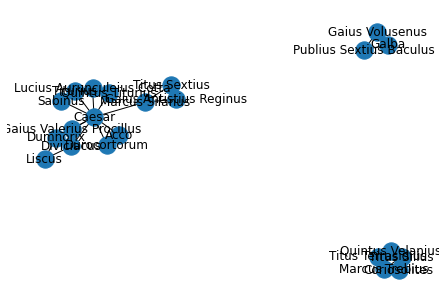

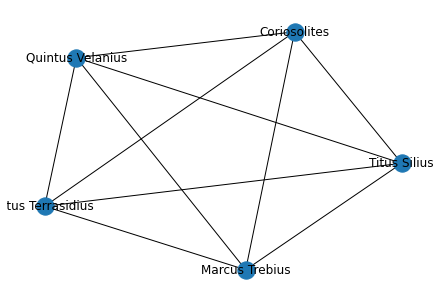

In [21]:
k2_core_subgraph = G.subgraph(nx.k_core(G, k=2))
k3_core_subgraph = G.subgraph(nx.k_core(G, k=3))

nx.draw(k2_core_subgraph, with_labels=True) # 2-cores subgraph
plt.show()

nx.draw(k3_core_subgraph, with_labels=True) # 3-cores subgraph
plt.show()


#### Cliques

In [22]:
cliques_list = sorted(list(nx.enumerate_all_cliques(G)), key=lambda x:len(x), reverse=True)

nx.find_cliques(G)
print(len([x for x in cliques_list if 'Caesar' not in x]))
print(len([x for x in cliques_list if len(x) > 2]))
print(len([x for x in cliques_list if len(x) > 2 and 'Caesar' not in x]))


124
23
18


In [23]:
import pandas as pd
import dataframe_image as dfi

# Create an empty DataFrame with the shared keys as the index
# and the dictionaries' keys as the column names
df = pd.DataFrame(index=list(degrees.keys()))
df['Degree'] = None
df['Degree c.'] = None
df['Betweenness c.'] = None
df['Closeness c.'] = None
df['Harmonic c.'] = None
df['Eigenvector c.'] = None

# Fill the DataFrame with the values from the dictionaries
for key, value in degrees.items():
    df.at[key, 'Degree'] = value
for key, value in degree_centrality.items():
    df.at[key, 'Degree c.'] = value
for key, value in betweenness_centrality.items():
    df.at[key, 'Betweenness c.'] = value
for key, value in closeness_centrality.items():
    df.at[key, 'Closeness c.'] = value
for key, value in harmonic_centrality.items():
    df.at[key, 'Harmonic c.'] = value
for key, value in eigenvector_centrality.items():
    df.at[key, 'Eigenvector c.'] = value

df.sort_values(by=list(df.columns), ascending=False, inplace=True)

df.to_csv('out/centrality_measures.csv', sep='\t', index=False)

df_styled = df.style.background_gradient()
dfi.export(df_styled,"out/centrality_measures.png")
df

,Degree,Degree c.,Betweenness c.,Closeness c.,Harmonic c.,Eigenvector c.
Caesar,20,0.327869,0.340437,0.400761,28.166667,0.660287
Lucius Aurunculeius Cotta,5,0.081967,0.039344,0.264031,18.5,0.239233
Titurius,4,0.065574,0.020492,0.260961,18.0,0.230338
Titus Terrasidius,4,0.065574,0.0,0.065574,4.0,0.000068
Marcus Trebius,4,0.065574,0.0,0.065574,4.0,0.000068
...,...,...,...,...,...,...
Terrasidius,1,0.016393,0.0,0.016393,1.0,0.0
Lucius Valerius Praeconinus,1,0.016393,0.0,0.016393,1.0,0.0
Lucius Manlius,1,0.016393,0.0,0.016393,1.0,0.0
Catuvolcus,1,0.016393,0.0,0.016393,1.0,0.0
